In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, RandomRotation, RandomCrop
from torchvision.datasets.mnist import MNIST
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
np.random.seed(0)
torch.manual_seed(0)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def create_patches(images, n_patches):
    """
    Create patches from input images.

    Args:
    - images (Tensor): Input images of shape (n, c, h, w).
    - n_patches (int): Number of patches per dimension.

    Returns:
    - Tensor: Patches of the images.
    """
    n, c, h, w = images.shape
    #This line extracts the dimensions of the input images stored in the images tensor. n is the number of images in the batch, c is the number of color channels (e.g., 3 for RGB),
    #and h and w are the height and width of the images, respectively.
    patch_size = h // n_patches
    #Here, the height (h) of the images is divided by n_patches to determine the size of each patch. It's assumed that the number of patches is the same in both height and width dimensions,
    #and that the height and width of the images are divisible by n_patches. The // operator performs integer division.
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.permute(0, 2, 3, 1, 4, 5).flatten(1, 2).flatten(2, -1)
    return patches

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d, n_heads=4):  # Increased number of heads
        """
        Initialize the MultiHeadSelfAttention module.

        Args:
        - d (int): Dimension of the input features.
        - n_heads (int): Number of attention heads.
        """
        super(MultiHeadSelfAttention, self).__init__()
        self.d = d
        self.n_heads = n_heads
        self.d_head = d // n_heads

        assert d % n_heads == 0, "Dimension must be divisible by the number of heads."

        self.q_mappings = nn.Linear(d, d)
        self.k_mappings = nn.Linear(d, d)
        self.v_mappings = nn.Linear(d, d)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        batch_size, seq_length, _ = sequences.size()

        q = self.q_mappings(sequences).view(batch_size, seq_length, self.n_heads, self.d_head).permute(0, 2, 1, 3)
        k = self.k_mappings(sequences).view(batch_size, seq_length, self.n_heads, self.d_head).permute(0, 2, 1, 3)
        v = self.v_mappings(sequences).view(batch_size, seq_length, self.n_heads, self.d_head).permute(0, 2, 1, 3)

        attention = self.softmax(torch.matmul(q, k.transpose(-2, -1)) / (self.d_head ** 0.5))
        output = torch.matmul(attention, v).permute(0, 2, 1, 3).contiguous().view(batch_size, seq_length, self.d)

        return output

class ViTBlock(nn.Module):
    def __init__(self, hidden_dim=64, n_heads=4, mlp_ratio=6):  # Increased hidden_dim and mlp_ratio
        """
        Initialize the Vision Transformer Block.

        Args:
        - hidden_dim (int): Dimension of hidden layers.
        - n_heads (int): Number of attention heads.
        - mlp_ratio (int): Ratio for the MLP dimension.
        """
        super(ViTBlock, self).__init__()
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.mhsa = MultiHeadSelfAttention(hidden_dim, n_heads)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, mlp_ratio * hidden_dim),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_dim, hidden_dim)
        )

    def forward(self, x):
        x = self.norm1(x)
        x = x + self.mhsa(x)
        x = x + self.mlp(x)
        return x

# VisionTransformer class and get_positional_embeddings function
# continue here...



In [4]:
class VisionTransformer(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=8, hidden_dim=64, n_heads=4, output_dim=10):
        """
        Initialize the Vision Transformer.

        Args:
        - chw (tuple): Channels, Height, and Width of the input image.
        - n_patches (int): Number of patches per dimension.
        - n_blocks (int): Number of transformer blocks.
        - hidden_dim (int): Dimension of hidden layers in the transformer blocks.
        - n_heads (int): Number of attention heads.
        - output_dim (int): Output dimension (number of classes for classification).
        """
        super(VisionTransformer, self).__init__()

        self.chw = chw
        self.n_patches = n_patches
        self.hidden_dim = hidden_dim

        assert chw[1] % n_patches == 0 and chw[2] % n_patches == 0, "Image dimensions must be divisible by the number of patches."
        self.patch_size = (chw[1] // n_patches, chw[2] // n_patches)

        self.input_dim = chw[0] * self.patch_size[0] * self.patch_size[1]
        self.linear_mapper = nn.Linear(self.input_dim, hidden_dim)
        self.class_token = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.positional_embeddings = nn.Parameter(torch.randn(1, n_patches**2 + 1, hidden_dim))

        self.blocks = nn.ModuleList([ViTBlock(hidden_dim, n_heads) for _ in range(n_blocks)])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, images):
        n, _, _, _ = images.shape
        patches = create_patches(images, self.n_patches)
        x = self.linear_mapper(patches).view(n, -1, self.hidden_dim)
        class_tokens = self.class_token.expand(n, -1, -1)
        x = torch.cat((class_tokens, x), dim=1)
        x += self.positional_embeddings

        for block in self.blocks:
            x = block(x)

        x = self.mlp_head(x[:, 0])
        return x


In [5]:
def get_positional_embeddings(sequence_length, d):
    positions = torch.arange(sequence_length, dtype=torch.float32).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d, 2, dtype=torch.float32) * -(torch.log(torch.tensor(10000.0)) / d))
    embeddings = torch.zeros(sequence_length, d)
    embeddings[:, 0::2] = torch.sin(positions / div_term)
    embeddings[:, 1::2] = torch.cos(positions / div_term)
    return embeddings


In [6]:
def data_augmentation(images):
    transform = nn.Sequential(
        RandomRotation(10),
        RandomCrop(28, padding=4)
    )
    augmented_images = [transform(image) for image in images]
    return torch.stack(augmented_images)


In [7]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, scheduler, device):
    n_epochs = 50  # You might want to adjust this for NAS

    best_accuracy = 0.0
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            x = data_augmentation(x)  # Apply data augmentation
            y_hat = model(x)
            loss = criterion(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        test_loss = 0.0
        accuracy = 0.0
        with torch.no_grad():
            for batch in test_loader:
                x, y = batch
                x, y = x.to(device), y.to(device)
                y_hat = model(x)
                loss = criterion(y_hat, y)
                test_loss += loss.item() * x.size(0)
                _, predicted_labels = torch.max(y_hat, 1)
                accuracy += (predicted_labels == y).sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy /= len(test_loader.dataset)
        best_accuracy = max(best_accuracy, accuracy)

        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

        # Adjust learning rate based on test loss
        scheduler.step(test_loss)

    return train_loss, best_accuracy


In [8]:
def visualize_predictions(model, data_loader, device, num_images=16):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(int(num_images**0.5), int(num_images**0.5), i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f'Actual: {labels[i].item()}, Predicted: {predicted[i].item()}')
        plt.axis('off')
    plt.show()


100%|██████████| 9912422/9912422 [00:00<00:00, 268095482.56it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 23668560.73it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 59047098.37it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15692363.07it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1/50, Train Loss: 1.8105, Test Loss: 0.9642, Accuracy: 0.6629
Epoch 2/50, Train Loss: 0.7481, Test Loss: 0.3040, Accuracy: 0.9103
Epoch 3/50, Train Loss: 0.4020, Test Loss: 0.1975, Accuracy: 0.9345
Epoch 4/50, Train Loss: 0.3025, Test Loss: 0.1698, Accuracy: 0.9480
Epoch 5/50, Train Loss: 0.2611, Test Loss: 0.1442, Accuracy: 0.9548
Epoch 6/50, Train Loss: 0.2297, Test Loss: 0.1556, Accuracy: 0.9521
Epoch 7/50, Train Loss: 0.2070, Test Loss: 0.1135, Accuracy: 0.9658
Epoch 8/50, Train Loss: 0.1947, Test Loss: 0.1056, Accuracy: 0.9663
Epoch 9/50, Train Loss: 0.1870, Test Loss: 0.1158, Accuracy: 0.9634
Epoch 10/50, Train Loss: 0.1725, Test Loss: 0.0906, Accuracy: 0.9736
Epoch 11/50, Train Loss: 0.1674, Test Loss: 0.0778, Accuracy: 0.9754
Epoch 12/50, Train Loss: 0.1592, Test Loss: 0.0914, Accuracy: 0.9719
Epoch 13/50, Train Loss: 0.1539, Test Loss: 0.1041, Accuracy: 0.9697
Epoch 00013: reducing learning rate o

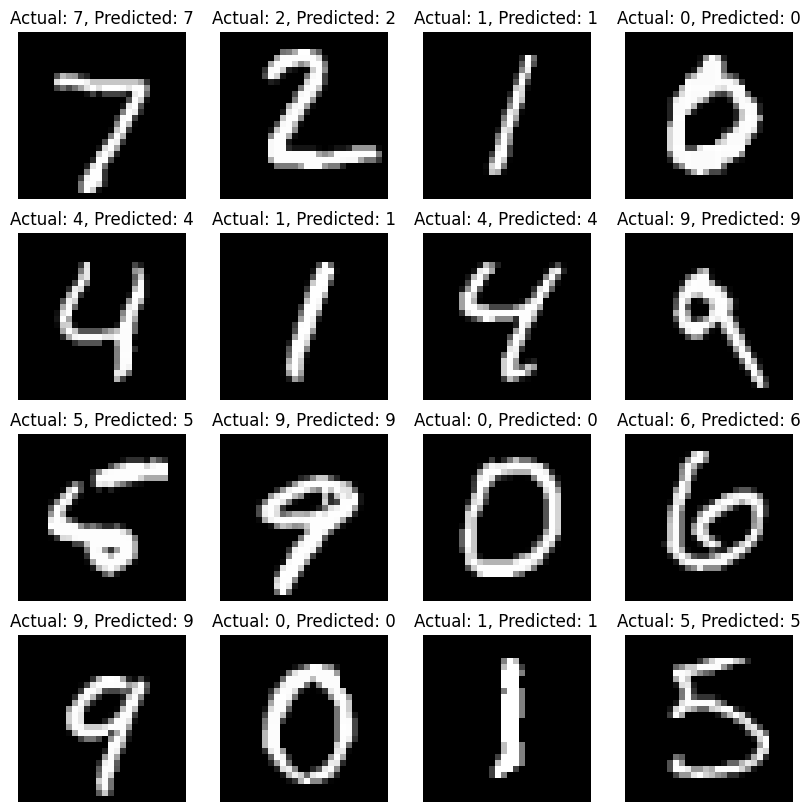

In [9]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
train_dataset = MNIST(root="./data", train=True, transform=ToTensor(), download=True)
test_dataset = MNIST(root="./data", train=False, transform=ToTensor(), download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create model
model = VisionTransformer(chw=(1, 28, 28)).to(device)

# Define loss function and optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

# Train and evaluate the model
train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, scheduler, device)

# Visualize predictions
visualize_predictions(model, test_loader, device)


In [11]:


for name, param in model.named_parameters():
    print(f"{name}: {param.size()}")


class_token: torch.Size([1, 1, 64])
positional_embeddings: torch.Size([1, 50, 64])
linear_mapper.weight: torch.Size([64, 16])
linear_mapper.bias: torch.Size([64])
blocks.0.norm1.weight: torch.Size([64])
blocks.0.norm1.bias: torch.Size([64])
blocks.0.mhsa.q_mappings.weight: torch.Size([64, 64])
blocks.0.mhsa.q_mappings.bias: torch.Size([64])
blocks.0.mhsa.k_mappings.weight: torch.Size([64, 64])
blocks.0.mhsa.k_mappings.bias: torch.Size([64])
blocks.0.mhsa.v_mappings.weight: torch.Size([64, 64])
blocks.0.mhsa.v_mappings.bias: torch.Size([64])
blocks.0.mlp.0.weight: torch.Size([384, 64])
blocks.0.mlp.0.bias: torch.Size([384])
blocks.0.mlp.2.weight: torch.Size([64, 384])
blocks.0.mlp.2.bias: torch.Size([64])
blocks.1.norm1.weight: torch.Size([64])
blocks.1.norm1.bias: torch.Size([64])
blocks.1.mhsa.q_mappings.weight: torch.Size([64, 64])
blocks.1.mhsa.q_mappings.bias: torch.Size([64])
blocks.1.mhsa.k_mappings.weight: torch.Size([64, 64])
blocks.1.mhsa.k_mappings.bias: torch.Size([64])
bloc

In [12]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")


Total number of parameters: 502794


In [13]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")


Number of trainable parameters: 502794
